# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, lit, min, max, split, udf, countDistinct, sum, count, isnan, when, count, col, size
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import array, lit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoderEstimator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml import Pipeline
from matplotlib.dates import DateFormatter

In [2]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()


# Load Dataset

In [3]:
# Read in full sparkify dataset
event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(event_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

# Exploratory Data Analysis

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
#cheking for NANs
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [6]:
# As there is no NaNs let's check the distribution of the authentication column 
df.groupBy('auth').agg(countDistinct('userId')).show()

+----------+----------------------+
|      auth|count(DISTINCT userId)|
+----------+----------------------+
|Logged Out|                     1|
| Cancelled|                    52|
|     Guest|                     1|
| Logged In|                   225|
+----------+----------------------+



In [7]:
#removing the guest and logged Out as they are not active users
df_filtered = df.filter((df.auth != 'Guest') & (df.auth != 'Logged Out'))

In [8]:
# Checking
df_filtered.groupBy('auth').agg(countDistinct('userId')).show()

+---------+----------------------+
|     auth|count(DISTINCT userId)|
+---------+----------------------+
|Cancelled|                    52|
|Logged In|                   225|
+---------+----------------------+



### I will create the churn collum with the cancelled value in the auth column.

In [9]:
#Creating the churn column as a dummy
cancelled = udf(lambda x : 0 if  x == 'Logged In' else 1, IntegerType())

In [10]:
df_clean = df_filtered.withColumn('churn',cancelled('auth'))

In [11]:
df_clean.groupBy('churn').agg(countDistinct('userId')).show()

+-----+----------------------+
|churn|count(DISTINCT userId)|
+-----+----------------------+
|    1|                    52|
|    0|                   225|
+-----+----------------------+



### The user can access the submit downgrade page before cancelling the paid account.

In [12]:
#see user activity
df_clean.groupBy('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [13]:
# Creating a new column with the page column as 1 if the user is downgraded
downgrade = udf(lambda x : 1 if  x == 'Submit Downgrade' else 0, IntegerType())
df_clean = df_clean.withColumn('Downgrade',downgrade('page'))

In [14]:
df_clean.groupBy('Downgrade').count().show()

+---------+------+
|Downgrade| count|
+---------+------+
|        1|    63|
|        0|278091|
+---------+------+



### As we can see there is more users that submited a downgrade than the ones that cancelled the account. Let's create the date column for further use

In [15]:
#creating the date column
df_clean = df_clean.withColumn("date", (F.from_unixtime(col('ts')/lit(1000))))
df_clean.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, Downgrade=0, date='2018-10-01 00:01:57'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', churn=0, Downgrade=0, date='2018-10-01 00:03:00')]

In [16]:
#Check if there is a gender bias
df_clean.groupBy('gender').agg(countDistinct('userId')).show()

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                   104|
|     M|                   121|
+------+----------------------+



### There are more male users, but the difference is less than 5%. So no problem here.

### In the next cells i will analyse the downgraded users versus the non-downgraded and the general users considering their activity in the page column

In [17]:
# get only the downgraded users
df_cancelled = df_clean.filter(df_clean.Downgrade == 1)

In [18]:
#double check
df_cancelled.groupBy('Downgrade').count().show()

+---------+-----+
|Downgrade|count|
+---------+-----+
|        1|   63|
+---------+-----+



In [19]:
# As we can see there is only one page entry in this dataframe
df_cancelled.select(count("page")).show()

+-----------+
|count(page)|
+-----------+
|         63|
+-----------+



In [20]:
# Retrieve the unique ids
ids = df_cancelled.select("userId").distinct()

In [21]:
ids.count()

49

In [22]:
#Getting only the data where the user has subimmited a downgrade
down = df_clean.join(ids, ['userId'], 'leftsemi')

In [23]:
# Check the page interations
down.groupBy('page').count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|              Cancel|    9|
|    Submit Downgrade|   63|
|         Thumbs Down| 1044|
|                Home| 3898|
|           Downgrade|  820|
|         Roll Advert| 1746|
|              Logout| 1253|
|       Save Settings|  101|
|Cancellation Conf...|    9|
|               About|  210|
|            Settings|  542|
|     Add to Playlist| 2496|
|          Add Friend| 1599|
|            NextSong|87035|
|           Thumbs Up| 4881|
|                Help|  561|
|             Upgrade|  226|
|               Error|   86|
|      Submit Upgrade|   73|
+--------------------+-----+



In [24]:
#Comparing the uniques Users in both dataframes:
df_clean.select(countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



In [25]:
down.select(countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                    49|
+----------------------+



In [26]:
# Comparing the total pages in each dataframe
df_clean.select(count("page")).show()

+-----------+
|count(page)|
+-----------+
|     278154|
+-----------+



In [27]:
down.select(count("page")).show()

+-----------+
|count(page)|
+-----------+
|     106652|
+-----------+



In [28]:
down.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- date: string (nullable = true)



### Each entry has a time stamp, with this we can get the 'age' of the user interaction.

In [104]:
# Transforming the registration date as a date.
df_clean = df_clean.withColumn("date_created", (F.from_unixtime(col('registration')/lit(1000))))


In [105]:
# Creating the difference between the creation and the activity
df_clean = df_clean.withColumn("time_from_creation", F.datediff('date','date_created'))

In [106]:
df_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, Downgrade=0, date='2018-10-01 00:01:57', date_created='2018-09-28 22:22:42', time_from_creation=3)]

In [107]:
#filtering the DF
df_time = df_clean.select(['Downgrade', 'userId', 'churn',"time_from_creation"]).toPandas()

In [108]:
df_time_agg = df_time.groupby(['userId']).time_from_creation.max()

In [109]:
df_time_agg.describe()

count    225.000000
mean      79.817778
std       37.625358
min        0.000000
25%       59.000000
50%       73.000000
75%      101.000000
max      256.000000
Name: time_from_creation, dtype: float64

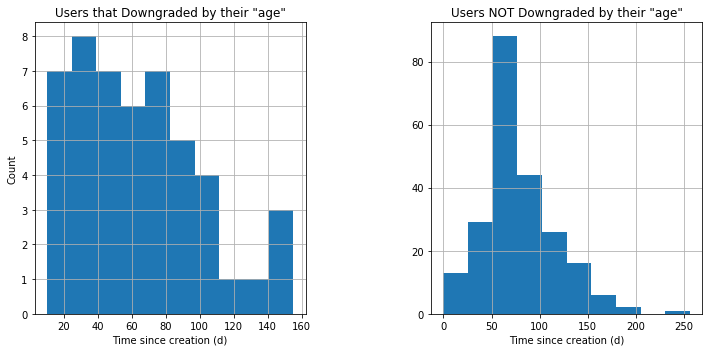

In [110]:
#Plotting the Downgraded distribution by both values
#df_time_agg = df_time.groupby(['userId']).time_from_creation.max()

#Subploting
figure, axis = plt.subplots(1, 2,figsize=(10, 5))

# Downgraded Plot
df_temp = df_time[df_time['Downgrade']==1].groupby(['userId']).time_from_creation.max()
df_temp.hist(ax=axis[0])
axis[0].set_title('Users that Downgraded by their "age"')
axis[0].set_ylabel('Count')
axis[0].set_xlabel('Time since creation (d)')

# Not Downgraded Plot
df_temp = df_time[df_time['Downgrade']==0].groupby(['userId']).time_from_creation.max()
df_temp.hist(ax=axis[1])
axis[1].set_title('Users NOT Downgraded by their "age"')
axis[1].set_xlabel('Time since creation (d)')

figure.tight_layout(w_pad = 10 )

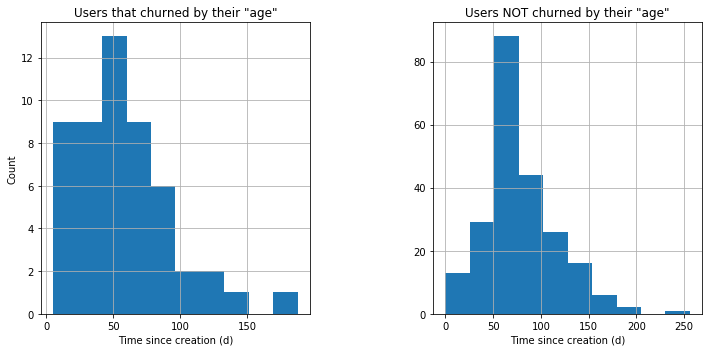

In [111]:
#Plotting the cancelled distribution by both values

#Subploting
figure, axis = plt.subplots(1, 2,figsize=(10, 5))

# Cancelled Plot
df_temp = df_time[df_time['churn']==1].groupby(['userId']).time_from_creation.max()
df_temp.hist(ax=axis[0])
axis[0].set_title('Users that churned by their "age"')
axis[0].set_ylabel('Count')
axis[0].set_xlabel('Time since creation (d)')

# Not Cancelled Plot
df_temp = df_time[df_time['churn']==0].groupby(['userId']).time_from_creation.max()
df_temp.hist(ax=axis[1])
axis[1].set_title('Users NOT churned by their "age"')
axis[1].set_xlabel('Time since creation (d)')

figure.tight_layout(w_pad = 10 )

The two groups are very different in their count, so we have to keep that in mind. The 'age' of the last user interaction since user admission showns almost a normal distribution with the mode close to 75 days. For the churn there is a break point in about 100 days. For the users that downgraded the break point is about 110 days. Both this groups don't last longer than the their opposite group, as expected, also they both reachs the max between one and two months. 

### Let's check if the user activity is different between paid and free users

In [60]:
# to use the date in the chart we need to transform the 'ts' column to unixtime
df_level = df_clean.select(['ts', 'level', 'sessionId'])

In [61]:
df_level = df_level.withColumn("date", F.to_date(F.from_unixtime(col('ts')/lit(1000)))).groupby(['date', 'level'])\
.agg(F.count('sessionId')).toPandas()

In [62]:
df_level.head()

,date,level,count(sessionId)
0,2018-10-27,free,548
1,2018-11-25,paid,2376
2,2018-10-24,paid,4577
3,2018-10-20,paid,4881
4,2018-10-20,free,816


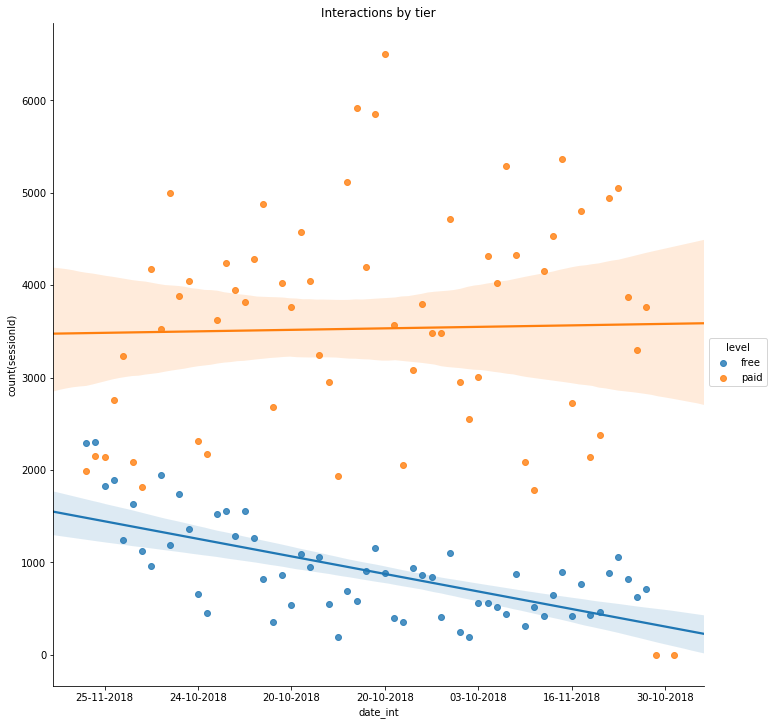

In [103]:
#Transform date to int for use in seaborn
df_level['date_int'] = df_level['date'].apply(lambda date: date.toordinal())
#Plotting
g = sns.lmplot(data= df_level, x="date_int",y='count(sessionId)', hue = 'level', size=10)
g = g.set_xticklabels(pd.to_datetime(df_level["date"]).dt.strftime('%d-%m-%Y'))
ax = plt.gca()
ax.set_title("Interactions by tier")
plt.show()

### The paid users are more active in general than the free ones. And there is a trend for the free users that shows their interactions are less significant in the total.

### What are the user activities? First we have to filter the method pages with the 'put' method. We have to remove the nextsong page as it is the majority of user activities.

In [29]:
pages_down = down.groupby('page','method').count().filter((down.method == 'PUT') & (down.page != 'NextSong')).toPandas()

In [30]:
pages_down.head()

,page,method,count
0,Add Friend,PUT,1599
1,Logout,PUT,1253
2,Submit Upgrade,PUT,73
3,Add to Playlist,PUT,2496
4,Cancel,PUT,9


Text(0,0.5,'')

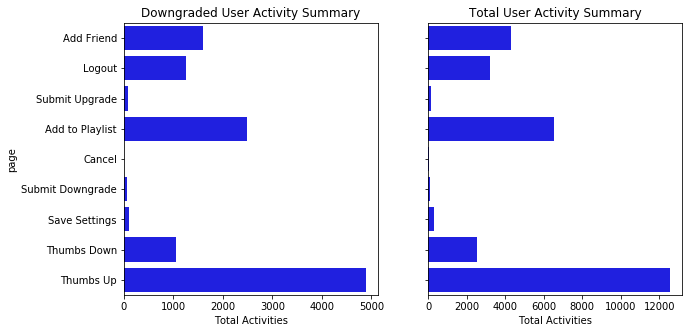

In [31]:
#Plotting
figure, axis = plt.subplots(1, 2,figsize=(10, 5), sharey=True)

#first graph with downgraded users
sns.barplot(data = pages_down, x='count', y='page' , orient ='h', color = 'blue', ax=axis[0])
axis[0].set_title('Downgraded User Activity Summary')
axis[0].set_xlabel('Total Activities')

#getting the non downgraded
pages = df_clean.groupby('page','method').count().filter((df_clean.method == 'PUT') & (df_clean.page != 'NextSong')).toPandas()

#plotting
sns.barplot(data = pages, x='count', y='page' , orient ='h', color='blue', ax=axis[1],  )
axis[1].set_title('Total User Activity Summary')
axis[1].set_xlabel('Total Activities')
axis[1].set_ylabel('')



### The user activity dosen't seen to be affected by the downgraded column as they have similar distributions.


### Let's see the location distribution

In [32]:
#create dataframe
location = df_clean.groupby('location','userId').agg(F.countDistinct('userId')).toPandas()

In [33]:
location.head()

,location,userId,count(DISTINCT userId)
0,"Atlanta-Sandy Springs-Roswell, GA",45,1
1,"Salinas, CA",200025,1
2,"Monroe, LA",100005,1
3,"Washington-Arlington-Alexandria, DC-VA-MD-WV",151,1
4,"Roanoke, VA",300005,1


In [34]:
#Separate the states
location['state'] =  location['location'].str.split(',', expand = True)[1]

In [35]:
location.head()

,location,userId,count(DISTINCT userId),state
0,"Atlanta-Sandy Springs-Roswell, GA",45,1,GA
1,"Salinas, CA",200025,1,CA
2,"Monroe, LA",100005,1,LA
3,"Washington-Arlington-Alexandria, DC-VA-MD-WV",151,1,DC-VA-MD-WV
4,"Roanoke, VA",300005,1,VA


In [36]:
states = location.groupby('state')['count(DISTINCT userId)'].sum().sort_values(ascending=False)

In [37]:
states.head()

state
 CA          33
 TX          16
 NY-NJ-PA    15
 FL          14
 AZ           7
Name: count(DISTINCT userId), dtype: int64

Text(0.5,1,'Distinct Users by State')

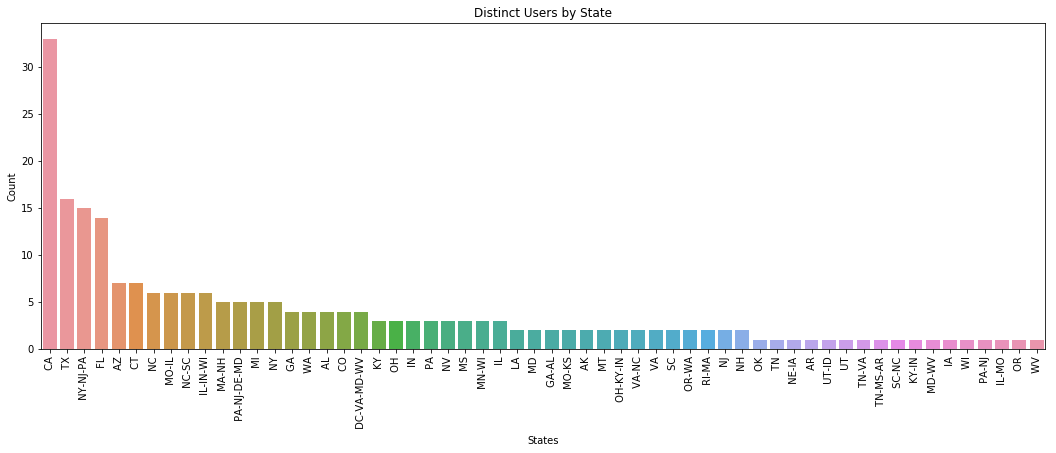

In [38]:
# plot the new series
plt.figure(figsize=(18, 6))
sns.barplot(states.index, states.values)

#rotate the x axis

plt.xticks(rotation=90)
plt.ylabel('Count')
plt.xlabel('States')
plt.title('Distinct Users by State')

### What's the time distribution of the users?

In [39]:
#Create a dataframe only with the time
time = df_clean.groupby('date', 'Downgrade').agg(F.countDistinct('userId')).toPandas()

In [40]:
time.head()

,date,Downgrade,count(DISTINCT userId)
0,2018-10-03 12:24:47,0,1
1,2018-10-14 03:01:09,0,1
2,2018-11-16 22:21:44,0,2
3,2018-10-02 13:18:18,0,1
4,2018-10-10 22:17:31,0,1


In [41]:
#Convert to datetime
time['date'] = pd.to_datetime(time['date'])

In [42]:
#Get hour
time['hour'] = time['date'].dt.hour

In [43]:
#Get week day
time['weekday'] = time['date'].dt.day_name()

In [44]:
time.head()

,date,Downgrade,count(DISTINCT userId),hour,weekday
0,2018-10-03 12:24:47,0,1,12,Wednesday
1,2018-10-14 03:01:09,0,1,3,Sunday
2,2018-11-16 22:21:44,0,2,22,Friday
3,2018-10-02 13:18:18,0,1,13,Tuesday
4,2018-10-10 22:17:31,0,1,22,Wednesday


Text(0.5,1,'Churned')

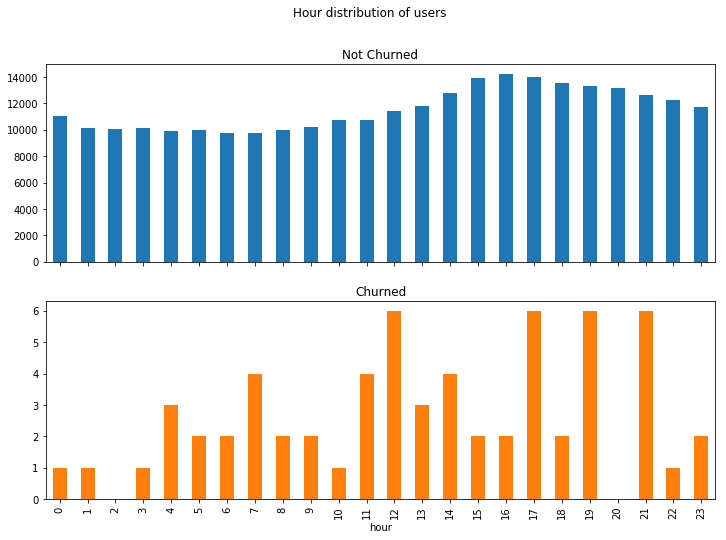

In [45]:
#Hour plot
hour =  time.groupby(['hour','Downgrade'])['count(DISTINCT userId)'].sum().sort_values(ascending=False).to_frame()


axes = hour.unstack().plot(kind='bar', subplots=True, figsize= (12,8), title = 'Hour distribution of users',\
                    legend = False,  )

axes[0].set_title('Not Churned')
axes[1].set_title('Churned')




Text(0.5,1,'Churned')

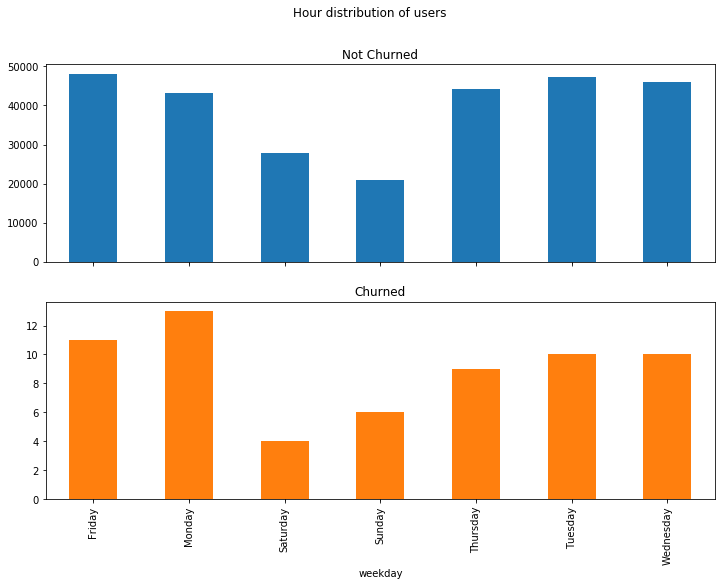

In [46]:
#week day plot
week =  time.groupby(['weekday', 'Downgrade'])['count(DISTINCT userId)'].sum().sort_values(ascending=False).to_frame()


axes = week.unstack().plot(kind='bar', subplots=True, figsize= (12,8), title = 'Hour distribution of users',\
                    legend = False,  )

axes[0].set_title('Not Churned')
axes[1].set_title('Churned')

### So the churned distribution has no hour pattern, probably due to low number of users.  But we can see that in both churned and not there is a week day pattern with less use in the weekends. For the not churned hour distribution we can see a greater usage after the 16h mark.

## Now i will transform the data from categorical to numeric for further use

In [112]:
# Convert gender to binary. 1 = female
female = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df_clean = df_clean.withColumn('gender_binary', female('gender'))

In [113]:
# Convert level to binary. 1 = paid
level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
df_clean = df_clean.withColumn('paid_user', level('level'))

In [114]:
# Convert songs played to binary.
songs = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
df_clean = df_clean.withColumn('played_song', songs('page'))

In [115]:
# Get user interactions except for playing songs
inter = ['Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend']
get_interactions = udf(lambda x: 1 if x in inter else 0, IntegerType())
df_clean = df_clean.withColumn('interactions', get_interactions('page'))

In [116]:
df_clean.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, Downgrade=0, date='2018-10-01 00:01:57', date_created='2018-09-28 22:22:42', time_from_creation=3, gender_binary=0, paid_user=1, played_song=1, interactions=0),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', 

In [117]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- date_created: string (nullable = true)
 |-- time_from_creation: integer (nullable = true)
 |-- gender_binary: integer (nullable = true)
 |-- paid_user: integer (nullable = true)
 |-- pl

### Here i create the model that will be evaluated for use in the Machine Learning

In [118]:
# Get model grouping the userId 
model = df_clean.groupby('userId').agg(\
                                                          max('churn').alias('churn_rate'),\
                                                          max('Downgrade').alias('Downgrade'),\
                                                          avg('time_from_creation').alias('time_from_creation'),\
                                                          max('gender_binary').alias('gender'),\
                                                          max('paid_user').alias('paid_user'),\
                                                          sum('played_song').alias('total_songs_played'),\
                                                          sum('interactions').alias('interactions'),\
                                         max('date').alias('date'),\
                                         max('date_created').alias('date_created'))

In [119]:
# getting the session time ('age')
model = model.withColumn("session_time", F.datediff('date','date_created'))

In [120]:
model = model.drop('date')

In [121]:
model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn_rate: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- time_from_creation: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- paid_user: integer (nullable = true)
 |-- total_songs_played: long (nullable = true)
 |-- interactions: long (nullable = true)
 |-- date_created: string (nullable = true)
 |-- session_time: integer (nullable = true)



In [122]:
model = model.toPandas()

In [123]:
model.head()

,userId,churn_rate,Downgrade,time_from_creation,gender,paid_user,total_songs_played,interactions,date_created,session_time
0,100010,0,0,32.719160,1,0,275,33,2018-09-27 02:45:40,55
1,200002,0,0,49.748945,0,1,387,39,2018-09-06 21:38:26,70
2,125,1,0,72.000000,0,0,8,0,2018-08-01 20:58:59,72
3,124,0,0,98.440207,1,1,4079,404,2018-07-22 01:52:15,131
4,51,1,0,11.103490,0,1,2111,201,2018-09-27 20:43:07,20


In [124]:
model.describe()

,churn_rate,Downgrade,time_from_creation,gender,paid_user,total_songs_played,interactions,session_time
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,0.231111,0.217778,60.169310,0.462222,0.733333,1013.813333,115.111111,79.817778
std,0.422483,0.413656,34.942479,0.499682,0.443203,1104.960779,127.092068,37.625358
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
25%,0.000000,0.000000,36.666667,0.000000,0.000000,230.000000,26.000000,59.000000
50%,0.000000,0.000000,51.064516,0.000000,1.000000,675.000000,76.000000,73.000000
75%,0.000000,0.000000,78.833795,1.000000,1.000000,1571.000000,171.000000,101.000000
max,1.000000,1.000000,230.464238,1.000000,1.000000,8002.000000,819.000000,256.000000


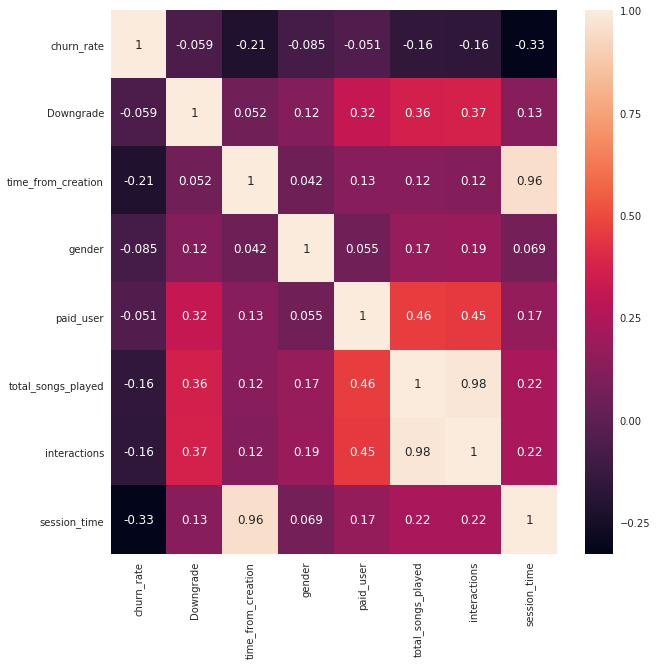

In [129]:
# Get correlations
plt.figure(figsize=(10, 10))
sns.heatmap(model.corr(), annot=True)

### As played songs is high correlated with interactions and has the same correlation with churn i will use only played songs

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [76]:
def clean_dataset(event_data):
    
    '''
    Take a event_data as a path to a spark dataframe in the json format. Selects the columns that will be used
    in the model, cleans the data, create dummies for the categoricals, create the date columns, balance
    the dataframe and outputs a model dataframe.

    Parameters:
    event_data : the path to the dataframe in the spark session in the format json (ex: 'mini_sparkify_event_data.json')

    Returns cleaned and balanced spark dataframe.
    '''

    
    df = spark.read.json(event_data)
    #selecting only the columns that will be used
    df=df.select(['gender', 'auth','page', 'ts', 'level', 'userId', 'page','registration'])

    #removing the guest and logged Out
    df_filtered = df.filter((df.auth != 'Guest') & (df.auth != 'Logged Out'))

    #Creating the churn column as a dummy
    cancelled = udf(lambda x : 0 if  x == 'Logged In' else 1, IntegerType())
    df_clean = df_filtered.withColumn('churn',cancelled('auth'))

    # Creating a new column with the page column as 1 if the user is downgraded
    downgrade = udf(lambda x : 1 if  x == 'Submit Downgrade' else 0, IntegerType())
    df_clean = df_clean.withColumn('Downgrade',downgrade('page'))


    #creating the date column
    df_clean = df_clean.withColumn("date", F.to_date(F.from_unixtime(col('ts')/lit(1000))))
    df_clean = df_clean.withColumn("date_created", F.to_date(F.from_unixtime(col('registration')/lit(1000))))
    df_clean = df_clean.withColumn("time_from_creation", F.datediff('date','date_created'))

    # Convert gender to binary. 1 = female
    female = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
    df_clean = df_clean.withColumn('gender_binary', female('gender'))

    # Convert level to binary. 1 = paid
    level = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
    df_clean = df_clean.withColumn('paid_user', level('level'))

    # Convert songs played to binary.
    songs = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
    df_clean = df_clean.withColumn('played_song', songs('page'))

    # Get user interactions except for playing songs
    inter = ['Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend']
    get_interactions = udf(lambda x: 1 if x in inter else 0, IntegerType())
    df_clean = df_clean.withColumn('interactions', get_interactions('page'))


    # Get the model
    model_df = df_clean.groupby('userId').agg(\
                                                              max('churn').alias('churn_rate'),\
                                                              max('Downgrade').alias('Downgrade'),\
                                                              avg('time_from_creation').alias('time_from_creation'),\
                                                              max('gender_binary').alias('gender'),\
                                                              max('paid_user').alias('paid_user'),\
                                                              sum('played_song').alias('total_songs_played'),\
                                                              sum('interactions').alias('interactions'),\
                                             max('date').alias('date'),\
                                             max('date_created').alias('date_created'))



    #Create a column with the session time and dropping the date column
    model_df = model_df.withColumn("session_time", F.datediff('date','date_created'))
    model_df = model_df.drop('date')
    
    #Ensuring that users with low interactions are considered as churned
    model_df = model_df.withColumn("churn_rate", \
              F.when( (model_df["churn_rate"]==1) | (model_df["interactions"] < 2), 1).otherwise(0))
    
    #Balancing the dataframe by the churn rate
    numerator = model_df.filter(model_df.churn_rate == 1).count()
    churned =  model_df.filter(model_df.churn_rate == 1)
    not_churned= model_df.filter(model_df.churn_rate == 0)
    denominator = not_churned.count()
    sample_df = not_churned.sample(withReplacement=False, fraction=numerator/denominator, seed=42)
    model_df = churned.union(sample_df)
    

    return model_df
    

In [77]:
#test
model = clean_dataset(event_data)

In [78]:
model.filter(model.churn_rate == 1)

DataFrame[userId: string, churn_rate: int, Downgrade: int, time_from_creation: double, gender: int, paid_user: int, total_songs_played: bigint, interactions: bigint, date_created: date, session_time: int]

In [79]:
model.take(1)

[Row(userId='125', churn_rate=1, Downgrade=0, time_from_creation=72.0, gender=0, paid_user=0, total_songs_played=8, interactions=0, date_created=datetime.date(2018, 8, 1), session_time=72)]

In [80]:
model.count()

111

In [81]:
model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn_rate: integer (nullable = false)
 |-- Downgrade: integer (nullable = true)
 |-- time_from_creation: double (nullable = true)
 |-- gender: integer (nullable = true)
 |-- paid_user: integer (nullable = true)
 |-- total_songs_played: long (nullable = true)
 |-- interactions: long (nullable = true)
 |-- date_created: date (nullable = true)
 |-- session_time: integer (nullable = true)



In [82]:
def model_preparation(model):
        
    '''
    Take a model as a spark dataframe with this columns = ['Downgrade','time_from_creation','gender','paid_user',
    'total_songs_played','interactions','session_time']. Uses the VectorAssembler on this columns and then uses
    the StandardScaler on this numeric features.

    Parameters:
    model : a spark dataframe

    Returns - Data prepared for machine learning with features and label columns.
    '''
    
    # Assemble num features
    assembler = VectorAssembler(inputCols=['Downgrade','time_from_creation','gender',\
                                       'paid_user','total_songs_played','interactions',\
                                      'session_time'],\
                            outputCol='numerical_features',handleInvalid = 'skip')
    
    #temp DF
    temp = assembler.transform(model)
    
    #Create Scaler
    scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='features')
    scaler_fit = scaler.fit(temp)
    
    data = scaler_fit.transform(temp)
    
    # Use 'churn' as model prediction label
    data = data.withColumnRenamed('churn_rate','label')
    
    return data

    
    

In [83]:
data = model_preparation(model)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [84]:
def baseline_ml(data):
            
    '''
    Take the data as a processed spark dataframe. Splits the data into train and test. Use 4 machine learnirg
    algorithms with the default settings: LogisticRegression, DecisionTreeClassifier(seed=42),
    RandomForestClassifier(seed=42),LinearSVC. Outputs prints for the baseline parameters : accuracy. f1-score,
    precision and recall.  
    

    Parameters:
    model : a processed spark dataframe

    Returns - Prints for the parameters
    '''
    
    
    # Split train test set
    train, test = data.randomSplit([0.8, 0.2], seed=42)
    
    # Initialize four models
    clf_LR = LogisticRegression()
    clf_DT = DecisionTreeClassifier(seed=42)
    clf_RF = RandomForestClassifier(seed=42)
    clf_SVM = LinearSVC()
    
    #Instanciate the evaluator
    evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")
    
    #Empty dic for the results
    results = {}

    for clf in [clf_LR, clf_DT, clf_RF, clf_SVM]:
        model_results = {}
        # get the classifier name
        clf_name = clf.__class__.__name__

        #Train
        model = clf.fit(train)

        #Predict
        pred = model.transform(test)

        #Get each model result, print and append to the results
        model_results['f1_test'] = evaluator.evaluate(pred.select('label','prediction'),{evaluator.metricName: 'f1'})
        model_results['precision'] = evaluator.evaluate(pred.select('label','prediction'),{evaluator.metricName: 'weightedPrecision'})
        model_results['recall'] = evaluator.evaluate(pred.select('label','prediction'),{evaluator.metricName: 'weightedRecall'})
        model_results['accuracy'] = evaluator.evaluate(pred.select('label','prediction'),{evaluator.metricName: 'accuracy'})

        print(clf_name)
        print('Test F1-score: ',model_results['f1_test'])
        results[clf_name] = model_results
    
    #prints the general output
    results_df = pd.DataFrame(results)
    return results_df
    
    

In [85]:
baseline_ml(data)

LogisticRegression
Test F1-score:  0.7979797979797979
DecisionTreeClassifier
Test F1-score:  0.7916666666666665
RandomForestClassifier
Test F1-score:  0.6875
LinearSVC
Test F1-score:  0.7493734335839599


,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,LinearSVC
accuracy,0.80000,0.800000,0.700000,0.750000
f1_test,0.79798,0.791667,0.687500,0.749373
precision,0.81250,0.857143,0.738095,0.752525
recall,0.80000,0.800000,0.700000,0.750000


### As the best model in general is the Logistic Regression i will proceed to tune this model:

In [86]:
# Get the params

clf_LR = LogisticRegression()
paramGrid = ParamGridBuilder().\
            addGrid(clf_LR.maxIter, [10, 100, 1000]).\
            addGrid(clf_LR.regParam, [0.01,0.1,10.0,100.0]).\
            build()

#Use the crossvalidation
crossval = CrossValidator(estimator=clf_LR,
                      estimatorParamMaps=paramGrid,
                      evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                      numFolds=3)

In [87]:
#Train model
train, test = data.randomSplit([0.8, 0.2], seed=42)
from workspace_utils import active_session
with active_session():
    cvModel_stack = crossval.fit(train)

In [88]:
#Predict
with active_session():
    pred = cvModel_stack.transform(test)

In [89]:
# Results
evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "f1"})))

F-1 Score:0.8496240601503762


In [90]:
# Get the best params
bestModel = cvModel_stack.bestModel
print ('Best Param (regParam): ', bestModel._java_obj.getRegParam())

print ('Best Param (MaxIter): ', bestModel._java_obj.getMaxIter())

print ('Best Param (elasticNetParam): ', bestModel._java_obj.getElasticNetParam())



Best Param (regParam):  0.01
Best Param (MaxIter):  10
Best Param (elasticNetParam):  0.0
